## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-07-17 09:48:47.830298: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 09:48:51.105385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-17 09:48:55.867379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib as npm

  au

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 54.9%
RAM Usage: 29.3%
Available RAM: 266.6G
Total RAM: 377.1G
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 0


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0


RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

In [ ]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [7]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset



In [8]:
# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(dataset='UKBB', parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Create datasets for each subnetwork
unique_networks = np.unique(network_labels)
network_datasets = {}
print("Creating datasets for each subnetwork...")

for network in unique_networks:
    # Create mask for current network
    network_mask = network_labels == network
    
    # Subset data for this network
    X_network = X_valid[network_mask]
    Y_network = Y_valid[network_mask][:, network_mask]
    coords_network = coords_valid[network_mask]
    
    # Create mapping from network indices to true indices
    network_indices = np.where(network_mask)[0]
    network2true_mapping = {i: valid2true_mapping[idx] for i, idx in enumerate(network_indices)}
    
    # Create dataset for this network
    network_datasets[network] = RegionPairDataset(
        X=X_network,
        Y=Y_network, 
        coords=coords_network,
        valid2true_mapping=network2true_mapping, 
        dataset='UKBB', 
        parcellation='S456'
    )
    print(f"Network {network}: {len(network_datasets[network])} region pairs")

# Create dataloaders for each network
batch_size = 512
network_dataloaders = {
    network: DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    ) for network, dataset in network_datasets.items()
}


Loading data...
Creating datasets for each subnetwork...
Network Cerebellum: 72 region pairs
Network Cont: 2652 region pairs
Network Default: 8190 region pairs
Network DorsAttn: 2070 region pairs
Network Limbic: 650 region pairs
Network SalVentAttn: 2162 region pairs
Network SomMot: 5852 region pairs
Network Subcortical: 2070 region pairs
Network Vis: 3660 region pairs


Load in model trained on full dataset

In [9]:
from models.transformer_models import SharedSelfAttentionCLSModel

# Set up base model with the same hyperparameters used for training
smt_base_model = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_base_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base.pt"))
smt_base_model.eval()
smt_base_model.to("cuda")


# Set up model with the same hyperparameters used for training
smt_cls_model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_cls_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_cls.pt"))
smt_cls_model.eval()
smt_cls_model.to("cuda")


  warnings.warn(



Number of learnable parameters in SMT model: 1399947


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [10]:
network_dataloaders

{'Cerebellum': <torch.utils.data.dataloader.DataLoader at 0x7faa2d472990>,
 'Cont': <torch.utils.data.dataloader.DataLoader at 0x7faa1666dc10>,
 'Default': <torch.utils.data.dataloader.DataLoader at 0x7faa1666f390>,
 'DorsAttn': <torch.utils.data.dataloader.DataLoader at 0x7faa19d1c9d0>,
 'Limbic': <torch.utils.data.dataloader.DataLoader at 0x7faa15c1d1d0>,
 'SalVentAttn': <torch.utils.data.dataloader.DataLoader at 0x7faa1a287890>,
 'SomMot': <torch.utils.data.dataloader.DataLoader at 0x7faa103ad5d0>,
 'Subcortical': <torch.utils.data.dataloader.DataLoader at 0x7faa103ae850>,
 'Vis': <torch.utils.data.dataloader.DataLoader at 0x7faa103af9d0>}

In [11]:
# # Collect attention for each subnetwork
network_info = {
    0: ('Cerebellum', 72),
    1: ('Cont', 2652), 
    2: ('Default', 8190),
    3: ('DorsAttn', 2070),
    4: ('Limbic', 650),
    5: ('SalVentAttn', 2162),
    6: ('SomMot', 5852),
    7: ('Subcortical', 2070),
    8: ('Vis', 3660)
}

In [12]:
saved = True

if saved != True: 
    for i in range(9):
        network_name, num_pairs = network_info[i]
        print(f'Processing {network_name} network ({num_pairs} region pairs)')
        
        predictions_base_sub, targets_base_sub = smt_base_model.predict(
            network_dataloaders[network_name],
            collect_attn=True,
            save_attn_path=f'attn_base_SMT_full_training_{network_name}.npy'
        )
        
        predictions_cls_sub, targets_cls_sub = smt_cls_model.predict(
            network_dataloaders[network_name],
            collect_attn=True, 
            save_attn_path=f'attn_cls_SMT_full_training_{network_name}.npy'
        )    

Evaluate attention heads

In [13]:
# Preliminaries

# Get valid genes from load_transcriptome
from data.data_load import load_transcriptome

X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')
valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')

# Create gene groups/tokens
token_chunk_size = 60
num_tokens = len(valid_refgenome) // token_chunk_size
gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)

# Get chromosome switch points
chrom_switches = []
for i in range(1, len(gene_tokens)):
    if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
        chrom_switches.append(i)

gene_tokens


valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

[{'token_id': 0,
  'genes': ['LOC729737',
   'LINC01128',
   'SAMD11',
   'PERM1',
   'HES4',
   'ISG15',
   'AGRN',
   'TNFRSF4',
   'B3GALT6',
   'ACAP3',
   'PUSL1',
   'DVL1',
   'MXRA8',
   'CCNL2',
   'ANKRD65',
   'FNDC10',
   'CDK11A',
   'GABRD',
   'RER1',
   'PEX10',
   'PLCH2',
   'HES5',
   'TNFRSF14',
   'ARHGEF16',
   'TPRG1L',
   'AJAP1',
   'CHD5',
   'TNFRSF25',
   'PLEKHG5',
   'NOL9',
   'PHF13',
   'CAMTA1',
   'PER3',
   'ERRFI1',
   'SLC45A1',
   'ENO1',
   'SLC2A5',
   'SPSB1',
   'TMEM201',
   'PIK3CD',
   'CLSTN1',
   'CTNNBIP1',
   'UBE4B',
   'PGD',
   'TARDBP',
   'MASP2',
   'SRM',
   'FBXO2',
   'FBXO44',
   'DRAXIN',
   'CLCN6',
   'NPPA',
   'NPPB',
   'VPS13D',
   'DHRS3',
   'LRRC38',
   'PDPN',
   'PRDM2',
   'KAZN',
   'EFHD2'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 1,
  'genes': ['AGMAT',
   'PLEKHM2',
   'SLC25A34',
   'UQCRHL',
   'SRARP',
   'SZRD1',
   'CROCCP2',
   'SDHB',
   'RCC2',
   'ARHGEF10L',
   'IGSF21',
   'ALDH4A1',
   'IFFO

In [14]:
# Get unique chromosomes
unique_chroms = []
for token in gene_tokens:
    if token['chromosome'] not in unique_chroms:
        unique_chroms.append(token['chromosome'])

print(f"Number of unique chromosomes: {len(unique_chroms)}")
print("\nUnique chromosomes:")
for chrom in unique_chroms:
    print(chrom)

# Count number of chromosome switches
num_switches = len(chrom_switches)
print(f"\nNumber of chromosome switch points: {num_switches}")

print("\nChromosome switch points (token indices):")
for i, switch_point in enumerate(chrom_switches):
    prev_chrom = gene_tokens[switch_point-1]['chromosome']
    curr_chrom = gene_tokens[switch_point]['chromosome']
    print(f"Switch {i+1}: Token {switch_point} - {prev_chrom} → {curr_chrom}")



Number of unique chromosomes: 23

Unique chromosomes:
NC_000001.11
NC_000002.12
NC_000003.12
NC_000004.12
NC_000005.10
NC_000006.12
NC_000007.14
NC_000008.11
NC_000009.12
NC_000010.11
NC_000011.10
NC_000012.12
NC_000013.11
NC_000014.9
NC_000015.10
NC_000016.10
NC_000017.11
NC_000018.10
NC_000019.10
NC_000020.11
NC_000021.9
NC_000022.11
NC_000023.11

Number of chromosome switch points: 22

Chromosome switch points (token indices):
Switch 1: Token 13 - NC_000001.11 → NC_000002.12
Switch 2: Token 21 - NC_000002.12 → NC_000003.12
Switch 3: Token 28 - NC_000003.12 → NC_000004.12
Switch 4: Token 33 - NC_000004.12 → NC_000005.10
Switch 5: Token 40 - NC_000005.10 → NC_000006.12
Switch 6: Token 46 - NC_000006.12 → NC_000007.14
Switch 7: Token 52 - NC_000007.14 → NC_000008.11
Switch 8: Token 56 - NC_000008.11 → NC_000009.12
Switch 9: Token 61 - NC_000009.12 → NC_000010.11
Switch 10: Token 66 - NC_000010.11 → NC_000011.10
Switch 11: Token 73 - NC_000011.10 → NC_000012.12
Switch 12: Token 80 - NC_

In [15]:
network_info = {
    0: ('Cont', 2652), 
    1: ('SomMot', 5852),
    2: ('Default', 8190),
    3: ('DorsAttn', 2070),
    4: ('SalVentAttn', 2162),
    5: ('Vis', 3660),
    6: ('Limbic', 650),
    7: ('Cerebellum', 72),
    8: ('Subcortical', 2070)
}

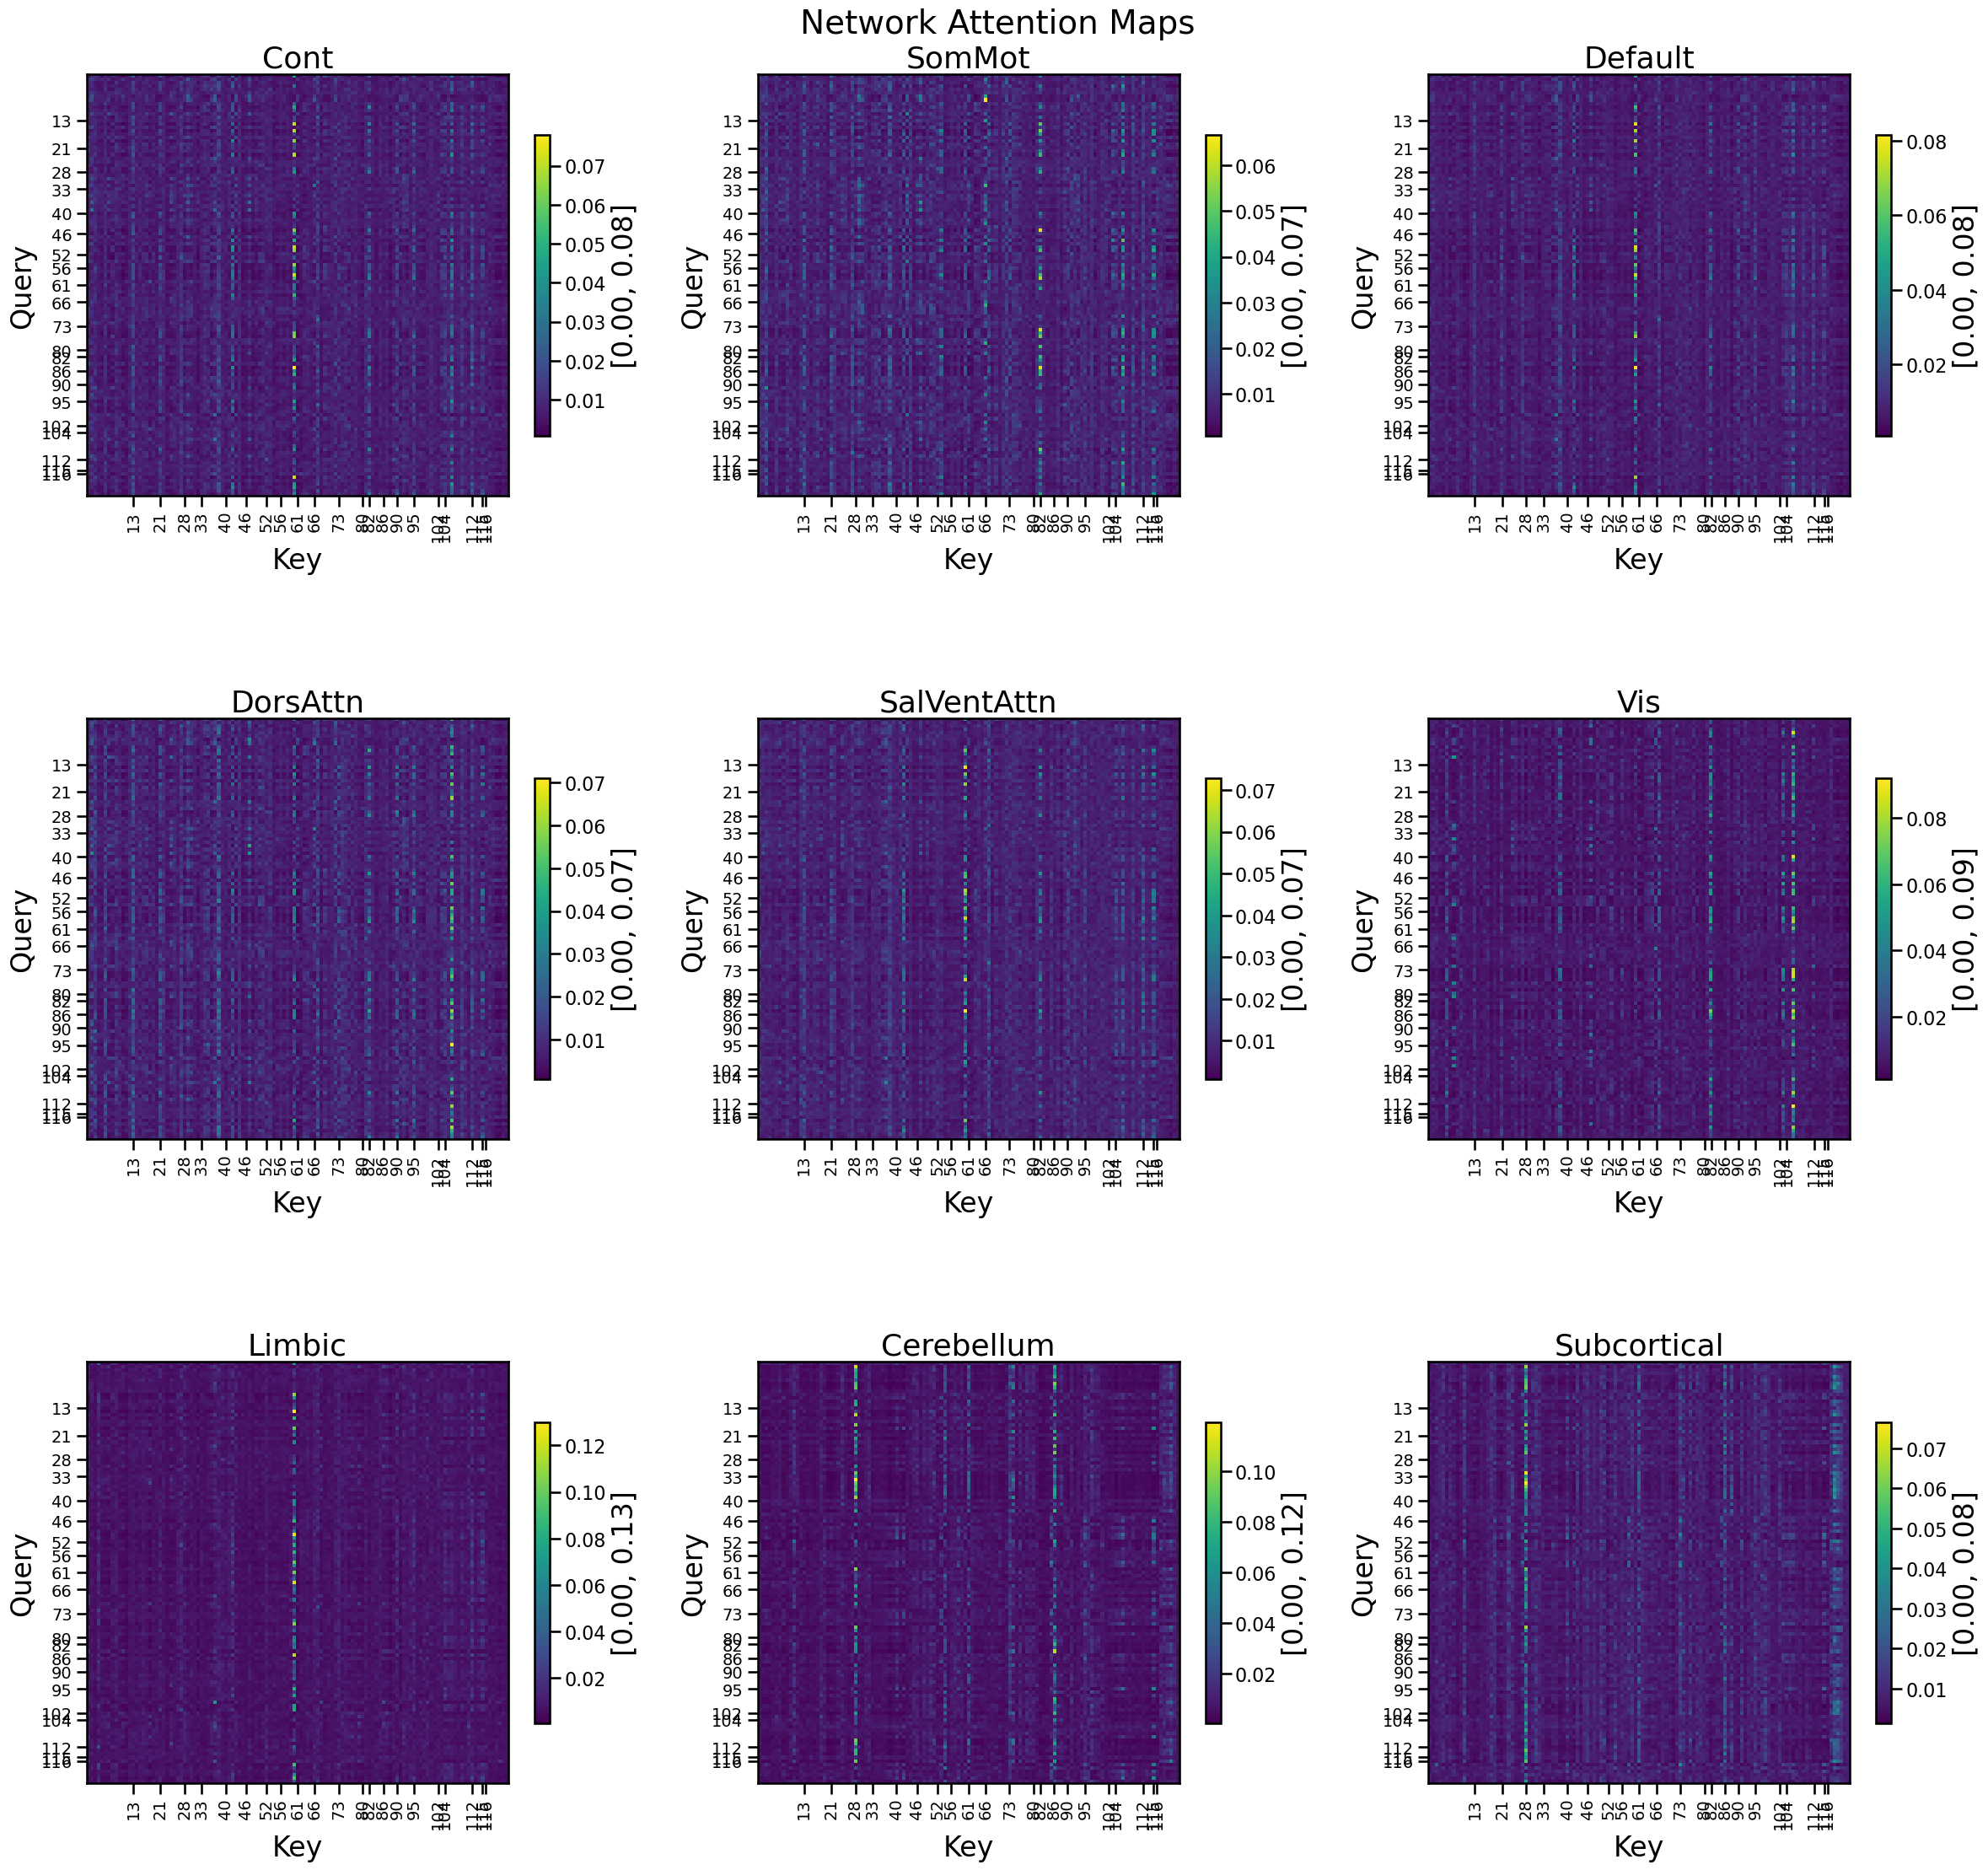

In [16]:
# Load attention weights for each network
network_attns = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    attn_path = f'notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training_{network_name}.npy'
    network_attns[network_name] = np.load(attn_path)

# Global font size parameter
FONTSIZE = 24

def plot_network_head(avg_attn, chrom_switches, network_name, ax):
    '''
    Plot average attention weights for a specific network
    '''
    chrom_switches = chrom_switches[:-1]

    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    
    vmin, vmax = avg_head.min(), avg_head.max()
    im = ax.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.5)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    ax.set_title(f"{network_name}", fontsize=FONTSIZE+2)
    ax.set_xlabel("Key", fontsize=FONTSIZE)
    ax.set_ylabel("Query", fontsize=FONTSIZE)
    ax.set_xticks(chrom_switches)
    ax.set_yticks(chrom_switches)
    ax.tick_params(axis='both', labelsize=FONTSIZE-10)
    plt.setp(ax.get_xticklabels(), rotation=90)


# Create 3x3 subplot grid
fig = plt.figure(figsize=(24, 24))
fig.suptitle("Network Attention Maps", fontsize=FONTSIZE+4, y=0.95)

# Plot attention weights for each network
for i, (network_name, attn) in enumerate(network_attns.items()):
    ax = plt.subplot(3, 3, i+1)
    plot_network_head(attn, chrom_switches, network_name, ax)

plt.tight_layout()
plt.show()


In [17]:
network_info = {
    0: ('Vis', 3660),
    1: ('SomMot', 5852), 
    2: ('DorsAttn', 2070),
    3: ('SalVentAttn', 2162),
    4: ('Cont', 2652),
    5: ('Default', 8190),
    6: ('Limbic', 650),
    7: ('Subcortical', 2070),
    8: ('Cerebellum', 72)
}

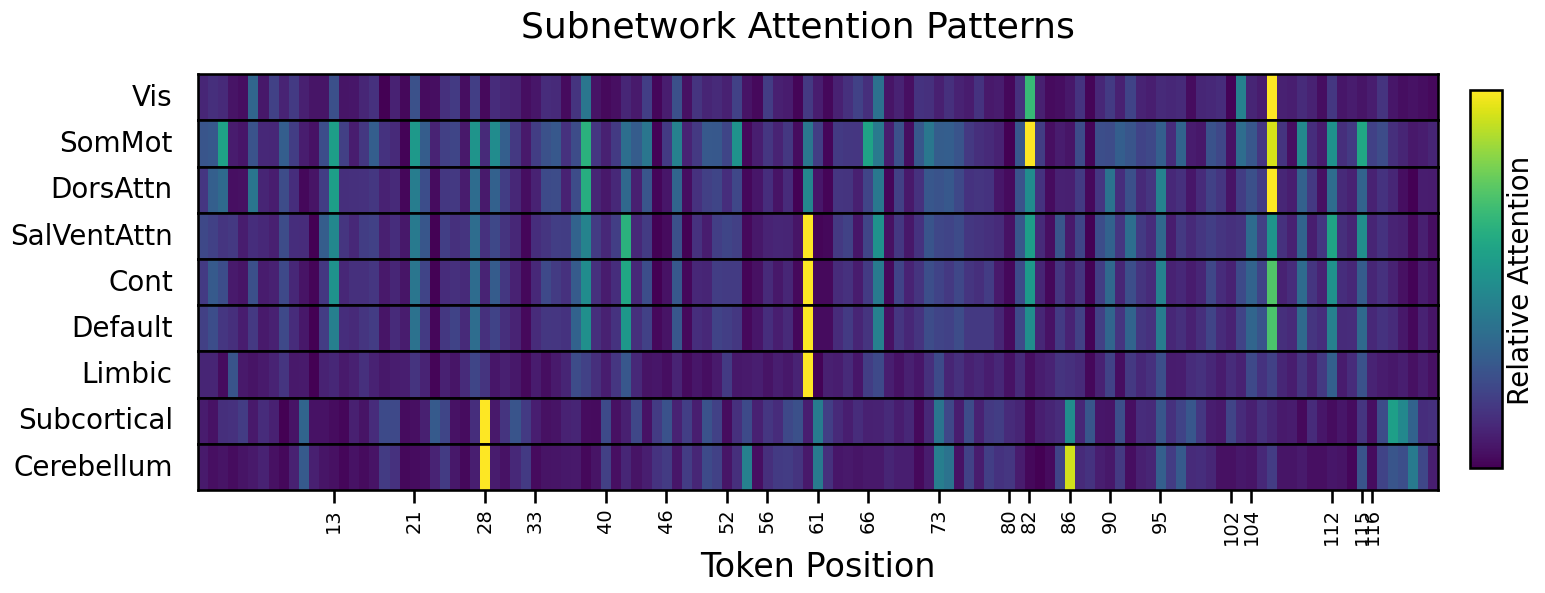

In [18]:
# Load attention weights for each network
network_attns = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    attn_path = f'notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training_{network_name}.npy'
    network_attns[network_name] = np.load(attn_path)

# Global font size parameter
FONTSIZE = 24

def plot_network_attention_rows(network_attns, chrom_switches, smooth=True):
    '''
    Plot attention weights for all networks as rows in separate subplots
    '''
    chrom_switches = chrom_switches[:-1]

    # Get number of networks and tokens
    n_networks = len(network_attns)
    n_tokens = next(iter(network_attns.values())).shape[1]
    
    # Create figure with subplots for each network
    fig, axes = plt.subplots(n_networks, 1, figsize=(16, 0.6*n_networks))
    fig.suptitle("Subnetwork Attention Patterns", fontsize=FONTSIZE+2, y=1.0)
    
    # Initialize matrix to store all attention values for normalization
    all_attention = np.zeros((n_networks, n_tokens))
    
    # First pass to get global min/max for normalization
    for i, (network_name, attn) in enumerate(network_attns.items()):
        avg_head = attn.mean(axis=0)
        row_data = np.sum(avg_head, axis=0)
        if smooth:
            from scipy.ndimage import gaussian_filter1d
            row_data = gaussian_filter1d(row_data, sigma=.5)
        all_attention[i] = row_data
    
    # Process each network's attention into a separate subplot
    for i, (network_name, attn) in enumerate(network_attns.items()):
        row_data = all_attention[i]
            
        # Plot heatmap for this network with local min/max scaling
        vmin, vmax = row_data.min(), row_data.max()
        im = axes[i].imshow(row_data.reshape(1,-1), cmap="viridis", 
                          aspect='auto', vmin=vmin, vmax=vmax)
        
        # Set labels and ticks with closer positioning
        axes[i].set_ylabel(network_name, fontsize=FONTSIZE-4, rotation=0, ha='right', va='center', labelpad=-150)
        
        # Only show x-axis labels on bottom subplot
        if i == n_networks-1:
            axes[i].set_xlabel("Token Position", fontsize=FONTSIZE)
            axes[i].set_xticks(chrom_switches)
            axes[i].tick_params(axis='x', labelsize=FONTSIZE-10, rotation=90)
        else:
            axes[i].set_xticks([])
        
        # Remove y-ticks since we have network names as labels
        axes[i].set_yticks([])
        
        # Move network labels closer to plots
        axes[i].yaxis.set_label_coords(-0.02, 0.5)

    # Add single colorbar for entire figure without ticks
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Relative Attention', fontsize=FONTSIZE-4)
    cbar.set_ticks([])

    plt.subplots_adjust(right=0.9, hspace=0.0)
    plt.show()

plot_network_attention_rows(network_attns, chrom_switches, smooth=False)


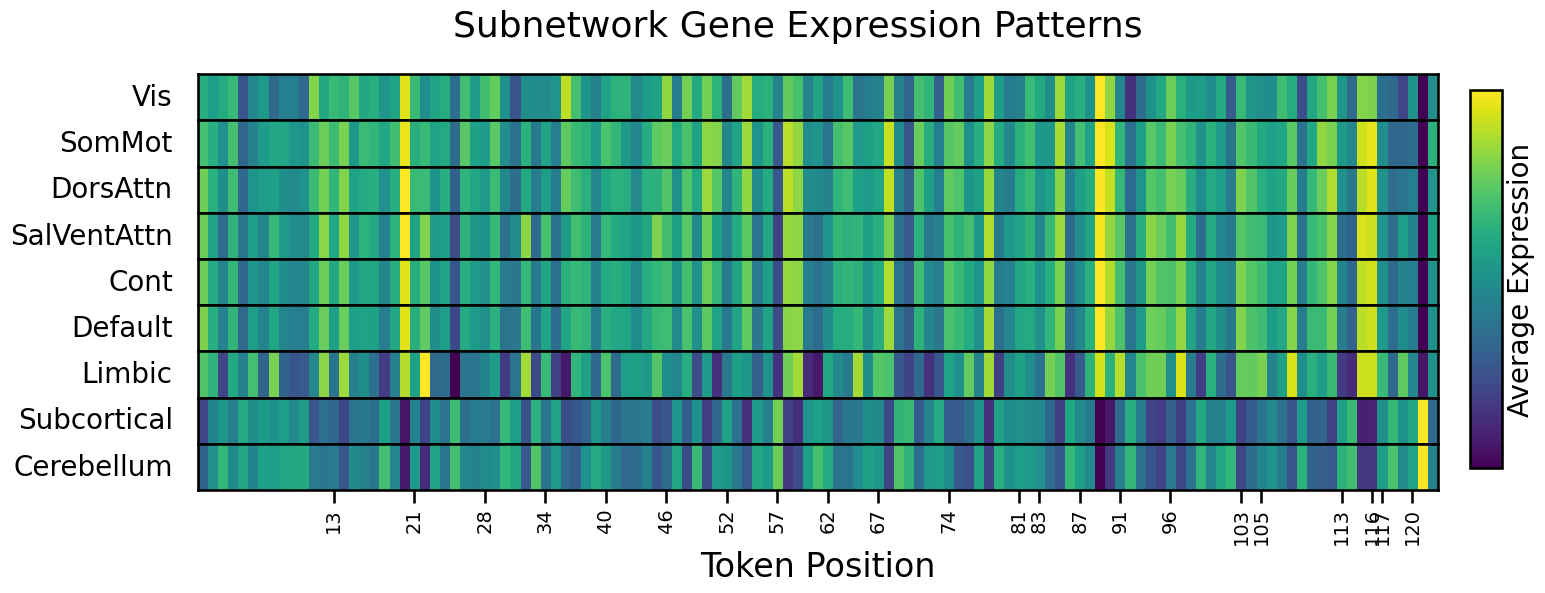

In [ ]:
# Load gene expression data and network labels
network_expr = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    # Get indices for this network
    network_mask = network_labels == network_name
    # Get expression data for nodes in this network
    network_expr[network_name] = X_valid[network_mask]

# Global font size parameter  
FONTSIZE = 24

def plot_network_expression_rows(network_expr, chrom_switches, token_dim=60, smooth=True):
    '''
    Plot average gene expression for all networks as rows in separate subplots,
    with genes grouped into chunks of token_dim size
    '''
    chrom_switches = chrom_switches[:-1]

    # Get number of networks and genes
    n_networks = len(network_expr)
    n_genes = X_valid.shape[1]
    
    # Calculate number of tokens based on gene chunks of token_dim size
    n_tokens = (n_genes + token_dim - 1) // token_dim  # Ceiling division
    
    # Create figure with subplots for each network
    fig, axes = plt.subplots(n_networks, 1, figsize=(16, 0.6*n_networks))
    fig.suptitle("Subnetwork Gene Expression Patterns", fontsize=FONTSIZE+2, y=1.0)
    
    # Initialize matrix to store all binned expression values
    all_expression = np.zeros((n_networks, n_tokens))
    
    # First pass to get binned expression values
    for i, (network_name, expr) in enumerate(network_expr.items()):
        # Average expression across nodes in network
        network_avg = expr.mean(axis=0)
        
        # Bin the genes into token-sized chunks
        binned_expr = np.zeros(n_tokens)
        for j in range(n_tokens):
            start_idx = j * token_dim
            end_idx = min(start_idx + token_dim, n_genes)
            binned_expr[j] = network_avg[start_idx:end_idx].mean()
            
        if smooth:
            from scipy.ndimage import gaussian_filter1d
            binned_expr = gaussian_filter1d(binned_expr, sigma=.5)
        all_expression[i] = binned_expr
    
    # Process each network's expression into a separate subplot
    for i, (network_name, expr) in enumerate(network_expr.items()):
        row_data = all_expression[i]
            
        # Plot heatmap for this network with local min/max scaling
        vmin, vmax = row_data.min(), row_data.max()
        im = axes[i].imshow(row_data.reshape(1,-1), cmap="viridis", 
                          aspect='auto', vmin=vmin, vmax=vmax)
        
        # Set labels and ticks with closer positioning
        axes[i].set_ylabel(network_name, fontsize=FONTSIZE-4, rotation=0, ha='right', va='center', labelpad=-150)
        
        # Only show x-axis labels on bottom subplot
        if i == n_networks-1:
            axes[i].set_xlabel("Token Position", fontsize=FONTSIZE)
            axes[i].set_xticks(chrom_switches)
            axes[i].tick_params(axis='x', labelsize=FONTSIZE-10, rotation=90)
        else:
            axes[i].set_xticks([])
        
        # Remove y-ticks since we have network names as labels
        axes[i].set_yticks([])
        
        # Move network labels closer to plots
        axes[i].yaxis.set_label_coords(-0.02, 0.5)

    # Add single colorbar for entire figure without ticks
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Average Expression', fontsize=FONTSIZE-4)
    cbar.set_ticks([])

    plt.subplots_adjust(right=0.9, hspace=0.0)
    plt.show()

plot_network_expression_rows(network_expr, chrom_switches, token_dim=60, smooth=False)


Base Model Average Attention:


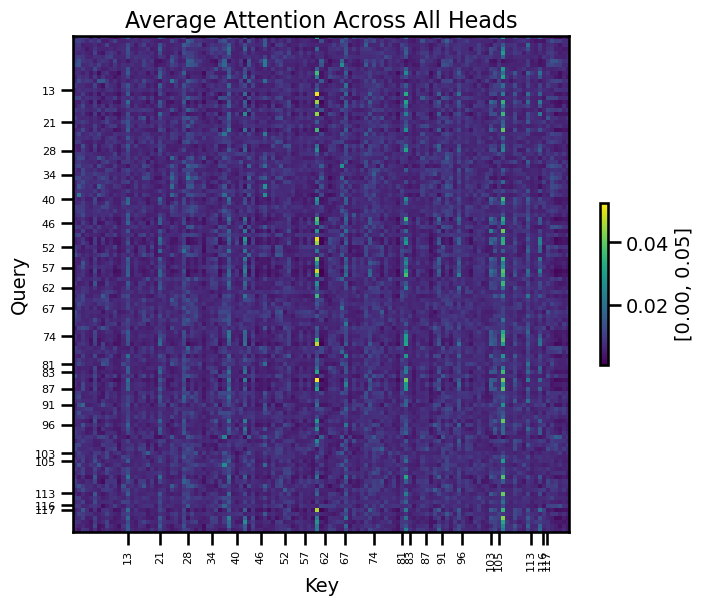

In [98]:
# Plot average attention heads separately
print("Base Model Average Attention:")
plot_average_head(avg_base_smt_attn, chrom_switches)


CLS Model Average Attention:


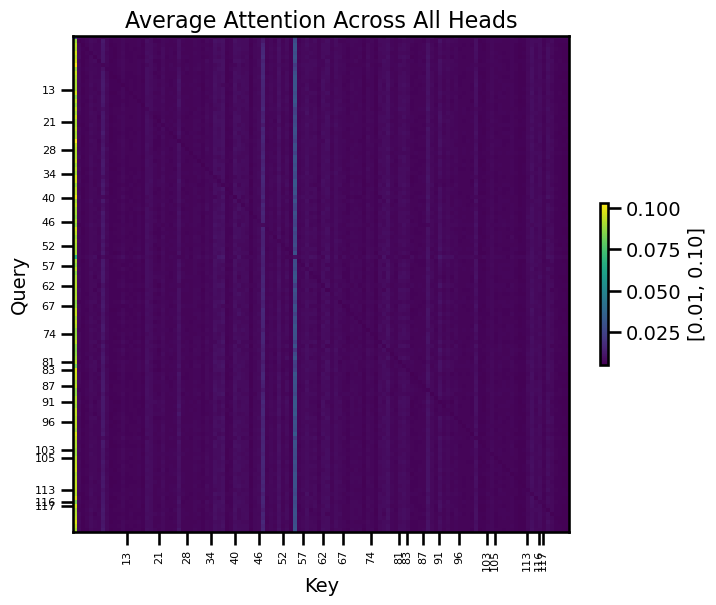


Genes in token:  54
['PKIA', 'ZC2HC1A', 'STMN2', 'HEY1', 'TPD52', 'ZBTB10', 'PAG1', 'FABP5', 'PMP2', 'IMPA1', 'E2F5', 'CA13', 'CA2', 'WWP1', 'RMDN1', 'CPNE3', 'MMP16', 'RIPK2', 'CALB1', 'NECAB1', 'PIP4P2', 'OTUD6B-AS1', 'OTUD6B', 'RUNX1T1', 'PDP1', 'GEM', 'RAD54B', 'FSBP', 'INTS8', 'MTERF3', 'SDC2', 'TSPYL5', 'MTDH', 'LAPTM4B', 'MATN2', 'RPL30', 'ERICH5', 'RIDA', 'NIPAL2', 'KCNS2', 'RGS22', 'POLR2K', 'PABPC1', 'YWHAZ', 'ZNF706', 'NCALD', 'RRM2B', 'UBR5', 'KLF10', 'GASAL1', 'AZIN1', 'AZIN1-AS1', 'ATP6V1C1', 'FZD6', 'SLC25A32', 'RIMS2', 'LRP12', 'ZFPM2', 'OXR1', 'ANGPT1']

Chromosome: NC_000008.11
PKIA ZC2HC1A STMN2 HEY1 TPD52 ZBTB10 PAG1 FABP5 PMP2 IMPA1 E2F5 CA13 CA2 WWP1 RMDN1 CPNE3 MMP16 RIPK2 CALB1 NECAB1 PIP4P2 OTUD6B-AS1 OTUD6B RUNX1T1 PDP1 GEM RAD54B FSBP INTS8 MTERF3 SDC2 TSPYL5 MTDH LAPTM4B MATN2 RPL30 ERICH5 RIDA NIPAL2 KCNS2 RGS22 POLR2K PABPC1 YWHAZ ZNF706 NCALD RRM2B UBR5 KLF10 GASAL1 AZIN1 AZIN1-AS1 ATP6V1C1 FZD6 SLC25A32 RIMS2 LRP12 ZFPM2 OXR1 ANGPT1


In [103]:
print("\nCLS Model Average Attention:") 
plot_average_head(avg_smt_cls_attn, chrom_switches)

true_token_num = 55 - 1
print("\nGenes in token: ", true_token_num)
print(gene_tokens[true_token_num]['genes'])
print("\nChromosome:", gene_tokens[true_token_num]['chromosome'])
print(' '.join(gene_tokens[true_token_num]['genes']))


In [108]:
true_token_num = 60
print("\nGenes in token: ", true_token_num)
print(gene_tokens[true_token_num]['genes'])
print("\nChromosome:", gene_tokens[true_token_num]['chromosome'])
print(' '.join(gene_tokens[true_token_num]['genes']))


Genes in token:  60
['GOLGA2', 'SWI5', 'URM1', 'TBC1D13', 'ENDOG', 'KYAT1', 'PHYHD1', 'SH3GLB2', 'PTPA', 'IER5L', 'LINC00963', 'NTMT1', 'ASB6', 'PTGES', 'NCS1', 'ASS1', 'FUBP3', 'FAM78A', 'PLPP7', 'PRRC2B', 'POMT1', 'NTNG2', 'DDX31', 'AK8', 'SURF1', 'SURF4', 'ADAMTS13', 'SLC2A6', 'ADAMTSL2', 'FAM163B', 'SARDH', 'VAV2', 'RXRA', 'COL5A1', 'OLFM1', 'PPP1R26', 'C9orf116', 'SOHLH1', 'KCNT1', 'NACC2', 'TMEM250', 'GPSM1', 'CARD9', 'PMPCA', 'SEC16A', 'EGFL7', 'SNHG7', 'LCN15', 'TMEM141', 'PHPT1', 'FBXW5', 'NPDC1', 'SAPCD2', 'MAN1B1-AS1', 'DPP7', 'TMEM203', 'RNF208', 'TUBB4B', 'NRARP', 'EXD3']

Chromosome: NC_000009.12
GOLGA2 SWI5 URM1 TBC1D13 ENDOG KYAT1 PHYHD1 SH3GLB2 PTPA IER5L LINC00963 NTMT1 ASB6 PTGES NCS1 ASS1 FUBP3 FAM78A PLPP7 PRRC2B POMT1 NTNG2 DDX31 AK8 SURF1 SURF4 ADAMTS13 SLC2A6 ADAMTSL2 FAM163B SARDH VAV2 RXRA COL5A1 OLFM1 PPP1R26 C9orf116 SOHLH1 KCNT1 NACC2 TMEM250 GPSM1 CARD9 PMPCA SEC16A EGFL7 SNHG7 LCN15 TMEM141 PHPT1 FBXW5 NPDC1 SAPCD2 MAN1B1-AS1 DPP7 TMEM203 RNF208 TUBB4B N

valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

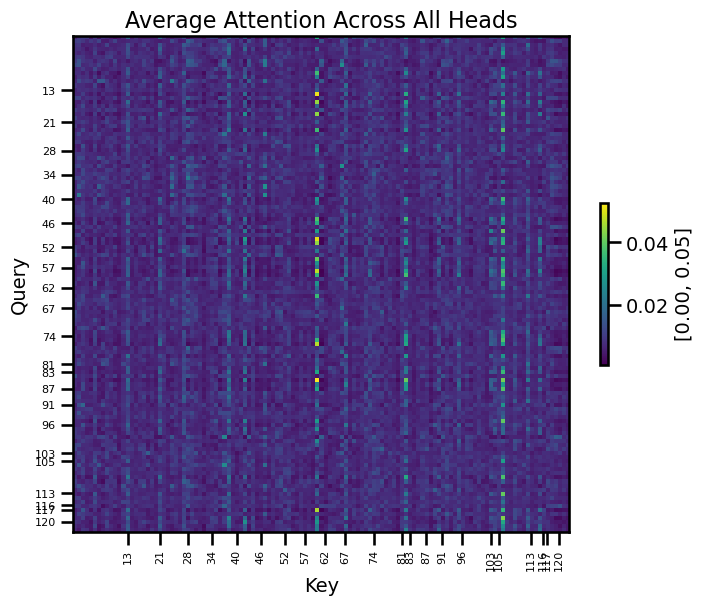


Genes in token 106:
['HSD11B1L', 'RPL36', 'LONP1', 'RFX2', 'MLLT1', 'KHSRP', 'SLC25A41', 'SLC25A23', 'DENND1C', 'C3', 'GPR108', 'VAV1', 'ZNF557', 'INSR', 'ARHGEF18', 'ZNF358', 'MCOLN1', 'CLEC4G', 'CLEC4M', 'TGFBR3L', 'CTXN1', 'TIMM44', 'ELAVL1', 'CERS4', 'KANK3', 'RAB11B', 'MYO1F', 'OR7E24', 'ZNF562', 'ZNF812P', 'FBXL12', 'UBL5', 'PIN1', 'OLFM2', 'COL5A3', 'C19orf66', 'S1PR2', 'MRPL4', 'ICAM5', 'FDX1L', 'ICAM3', 'CDC37', 'PDE4A', 'KEAP1', 'ATG4D', 'KRI1', 'CDKN2D', 'SLC44A2', 'LDLR', 'FH', 'RAB3D', 'TMEM205', 'PLPPR2', 'ELAVL3', 'ZNF653', 'ECSIT', 'CNN1', 'ELOF1', 'ZNF844', 'ZNF136']

Chromosome: NC_000019.10
HSD11B1L RPL36 LONP1 RFX2 MLLT1 KHSRP SLC25A41 SLC25A23 DENND1C C3 GPR108 VAV1 ZNF557 INSR ARHGEF18 ZNF358 MCOLN1 CLEC4G CLEC4M TGFBR3L CTXN1 TIMM44 ELAVL1 CERS4 KANK3 RAB11B MYO1F OR7E24 ZNF562 ZNF812P FBXL12 UBL5 PIN1 OLFM2 COL5A3 C19orf66 S1PR2 MRPL4 ICAM5 FDX1L ICAM3 CDC37 PDE4A KEAP1 ATG4D KRI1 CDKN2D SLC44A2 LDLR FH RAB3D TMEM205 PLPPR2 ELAVL3 ZNF653 ECSIT CNN1 ELOF1 ZNF844

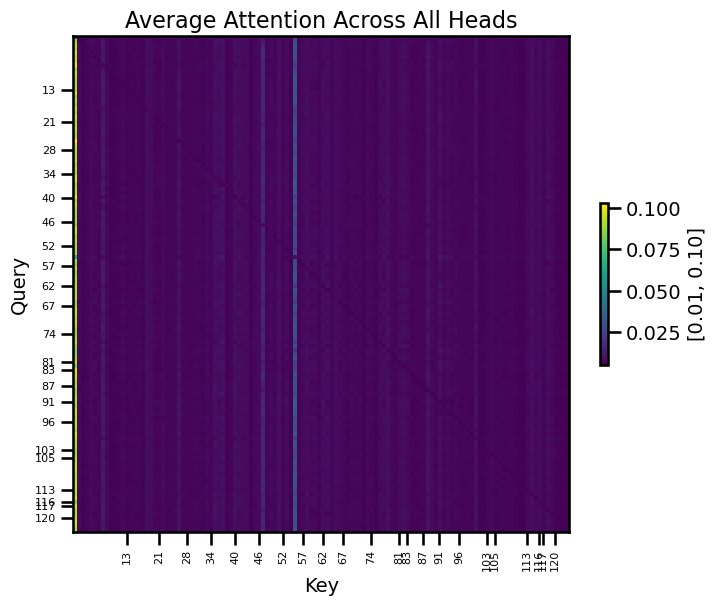


Genes in token 53:
['SFRP1', 'NKX6-3', 'ANK1', 'AP3M2', 'PLAT', 'IKBKB', 'SLC20A2', 'SMIM19', 'ASNSP1', 'SPIDR', 'SNTG1', 'RB1CC1', 'OPRK1', 'ATP6V1H', 'RGS20', 'LYPLA1', 'MRPL15', 'XKR4', 'TGS1', 'LYN', 'RPS20', 'CHCHD7', 'SDR16C5', 'PENK', 'SDCBP', 'NSMAF', 'TOX', 'CA8', 'CHD7', 'CLVS1', 'ASPH', 'NKAIN3', 'TTPA', 'MIR124-2HG', 'BHLHE22', 'CYP7B1', 'MTFR1', 'CRH', 'RRS1', 'C8orf46', 'MYBL1', 'C8orf44', 'PPP1R42', 'COPS5', 'PREX2', 'C8orf34', 'SULF1', 'LACTB2', 'XKR9', 'EYA1', 'KCNB2', 'RDH10', 'STAU2', 'UBE2W', 'ELOC', 'TMEM70', 'LY96', 'CRISPLD1', 'ZFHX4-AS1', 'ZFHX4']

Chromosome: NC_000008.11
SFRP1 NKX6-3 ANK1 AP3M2 PLAT IKBKB SLC20A2 SMIM19 ASNSP1 SPIDR SNTG1 RB1CC1 OPRK1 ATP6V1H RGS20 LYPLA1 MRPL15 XKR4 TGS1 LYN RPS20 CHCHD7 SDR16C5 PENK SDCBP NSMAF TOX CA8 CHD7 CLVS1 ASPH NKAIN3 TTPA MIR124-2HG BHLHE22 CYP7B1 MTFR1 CRH RRS1 C8orf46 MYBL1 C8orf44 PPP1R42 COPS5 PREX2 C8orf34 SULF1 LACTB2 XKR9 EYA1 KCNB2 RDH10 STAU2 UBE2W ELOC TMEM70 LY96 CRISPLD1 ZFHX4-AS1 ZFHX4
Note: Gene lists 

In [112]:
# Setup 
# Get valid genes from load_transcriptome
from data.data_load import load_transcriptome

X, valid_genes = load_transcriptome(parcellation='S400', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')
valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)]

# Create gene groups/tokens
token_chunk_size = 60
num_tokens = len(valid_refgenome) // token_chunk_size
gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)

# Get chromosome switch points
chrom_switches = []
for i in range(1, len(gene_tokens)):
    if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
        chrom_switches.append(i)
chrom_switches = chrom_switches[:-1]


def plot_attention_and_genes(attention_weights, chrom_switches, token_idx, is_cls_model=False, gene_tokens=gene_tokens):
    """
    Plot average attention head and print genes for specified token index
    
    Args:
        attention_weights: attention weight matrix
        chrom_switches: chromosome boundary indices
        token_idx: token index to analyze
        is_cls_model: whether attention is from CLS model
        gene_tokens: dictionary mapping token indices to gene information
    """
    # Plot average attention head
    print("Average Attention Head:")
    plot_average_head(attention_weights, chrom_switches)
    
    # Adjust token index for CLS model
    print_idx = token_idx - 1 if is_cls_model else token_idx
    
    print(f"\nGenes in token {print_idx}:")
    print(gene_tokens[print_idx]['genes'])
    print("\nChromosome:", gene_tokens[print_idx]['chromosome'])
    print(' '.join(gene_tokens[print_idx]['genes']))

# Example usage:
# For base model
plot_attention_and_genes(avg_base_smt_attn, chrom_switches, 106, is_cls_model=False)

# For CLS model  
plot_attention_and_genes(avg_smt_cls_attn, chrom_switches, 54, is_cls_model=True)

print("Note: Gene lists for any token can be manually passed into https://biit.cs.ut.ee/gprofiler/gost for quick functional profiling")
